In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

from collections import OrderedDict

import datetime as dt
from datetime import date
from datetime import datetime

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
import joblib

import numpy as np
np.random.seed(0)
import scipy

import datetime as dt
from datetime import date

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

#Funktion für RMSE erstellen
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

## <font size="7">LSTM-DENSE-1</font><a class="anchor" id="lstm-dense-1"></a>

<font size="5">
Im Rahmen dieses Ansatzes wird die LSTM-Schicht durch eine zusätzliche („normale“) Dense-Schicht erweitert. Die Dense-Schicht soll die durch die LSTM-Schicht geschleusten Daten zusätzlich nachverarbeiten. Dafür werden in der LSTM- und Dense-Schicht jeweils 32 Neuronen eingefügt, die mit Tanh aktiviert werden.
<font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=False, activation="tanh"))
    model.add(Dense(units=32, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.48            1.65               1.81
2             2.41            1.74               1.78
3             2.62            1.84               1.90
4             2.29            1.65               1.99
5             2.49            2.01               1.97
Average       2.46            1.78               1.89





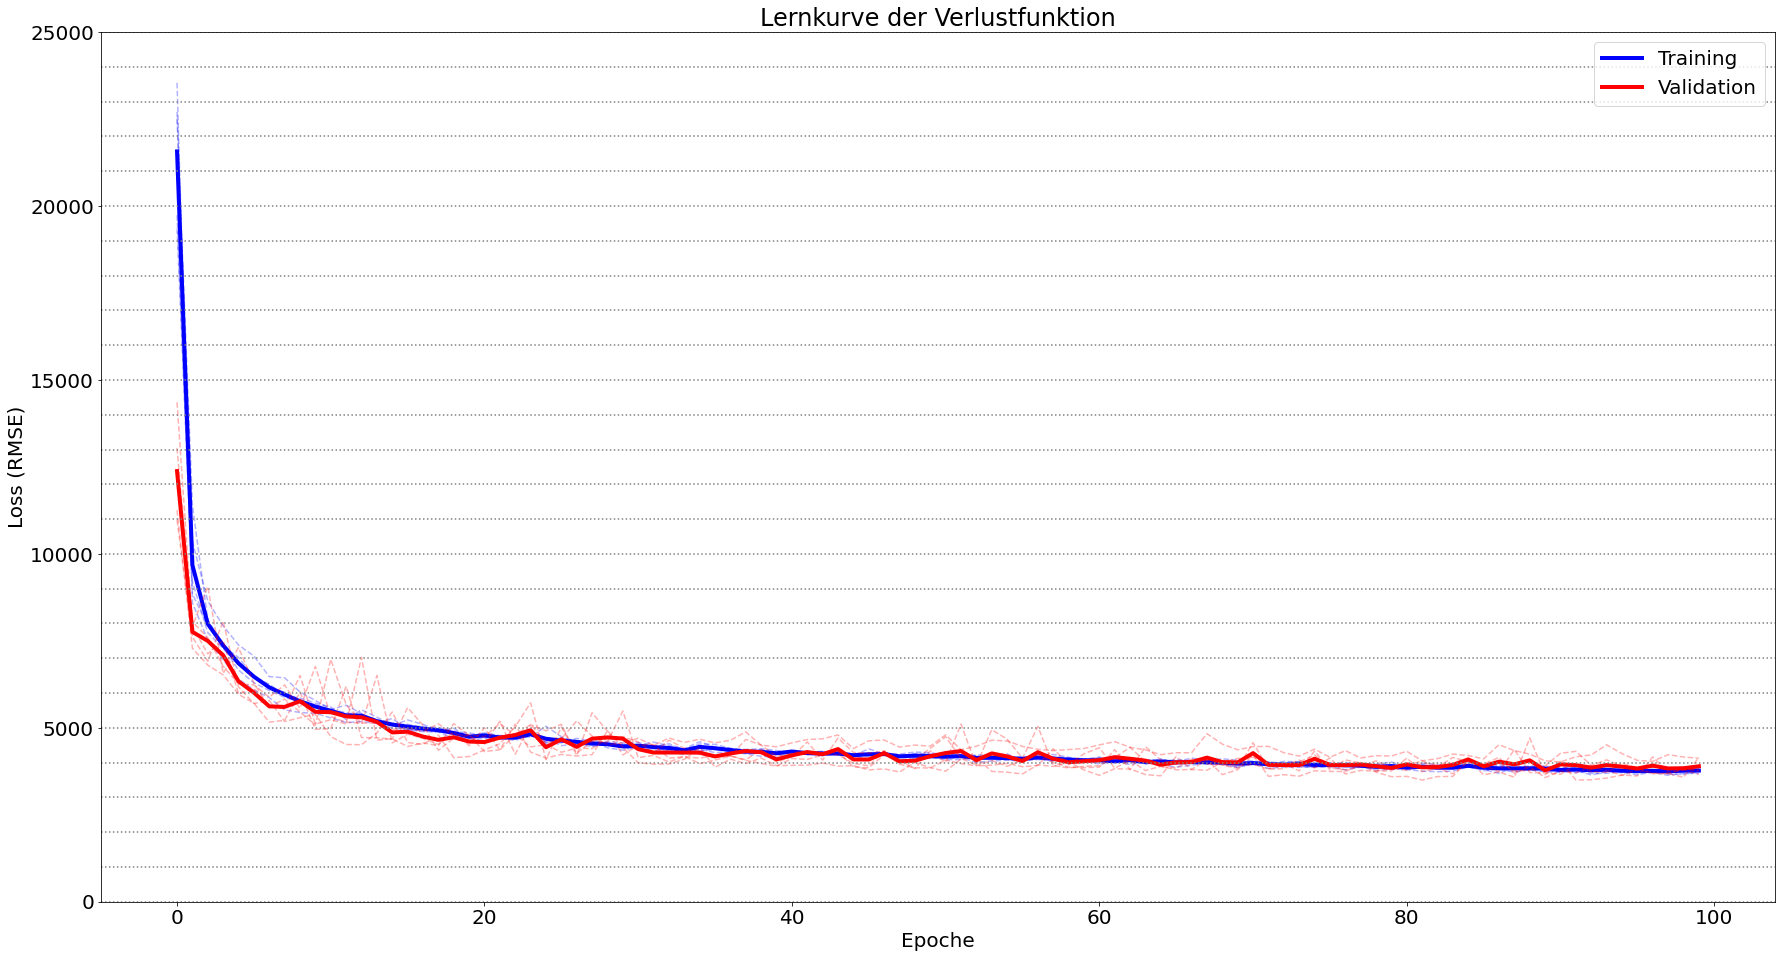

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 25000)

<font size="5">
Die zusätzliche Dense-Schicht führt beim Training weder zu einer Verbesserung auf den Trainings-, noch auf den Testdaten. Die Lernkurve verhält sich ähnlich wie bei den reinen LSTM-Modellen, allerdings setzt die Konvergenz etwas früher ein. Dies kann aber auch an der geringeren Anzahl von Neuronen liegen.
</font>
<br><br>
<font size="5">
Beim finalen Test schneidet das Modell mit einem MAPE von 2,74% auf den Testdaten relativ schlecht ab. Auch die Trainingsdaten werden mit einer Abweichung von 1,93% nicht gut erkannt. Es handelt sich also eher um ein unterangepasstes Modell.
</font>


### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 2s 4ms/step - loss: 0.1218
Epoch 2/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0663
Epoch 3/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0577
Epoch 4/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0521
Epoch 5/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0492
Epoch 6/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0469
Epoch 7/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0447
Epoch 8/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0434
Epoch 9/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0436
Epoch 10/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0409
Epoch 11/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0414
Epoch 12/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0401
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.95           0.97
MAE       4582.0         3202.0
MSE   32860335.0     18666035.0
RMSE      5732.0         4320.0
                               
MAPE      2.74 %         1.93 %


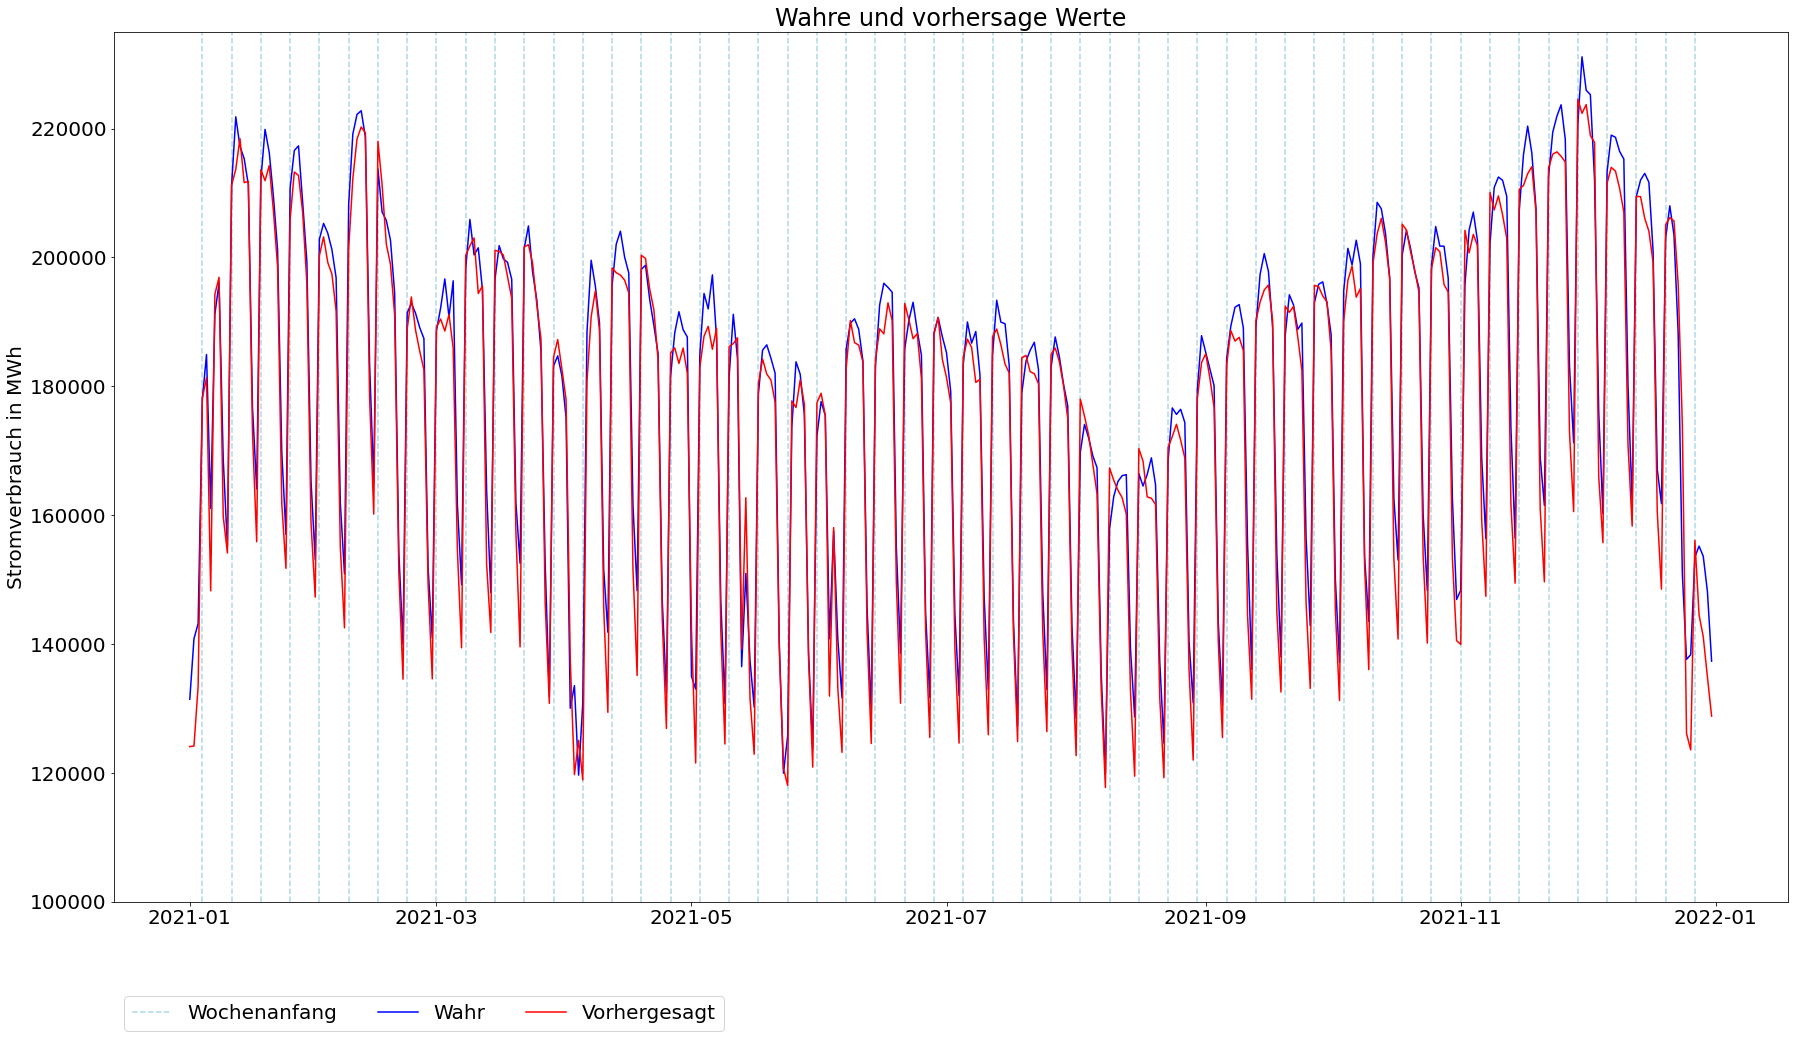

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-DENSE-2</font><a class="anchor" id="lstm-dense-2"></a>

<font size="5">
Da sich das Modell bei 32 Neuronen etwas unteranpasst, wird versucht, das Modell durch mehr Neuronen in der Desnse-Schicht (64) zu erweitern.
<font>


### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=False, activation="tanh"))
    model.add(Dense(units=64, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.33            1.74               1.85
2             2.40            1.72               1.75
3             2.33            1.75               1.77
4             2.48            1.81               2.09
5             2.25            1.76               1.81
Average       2.36            1.76               1.85





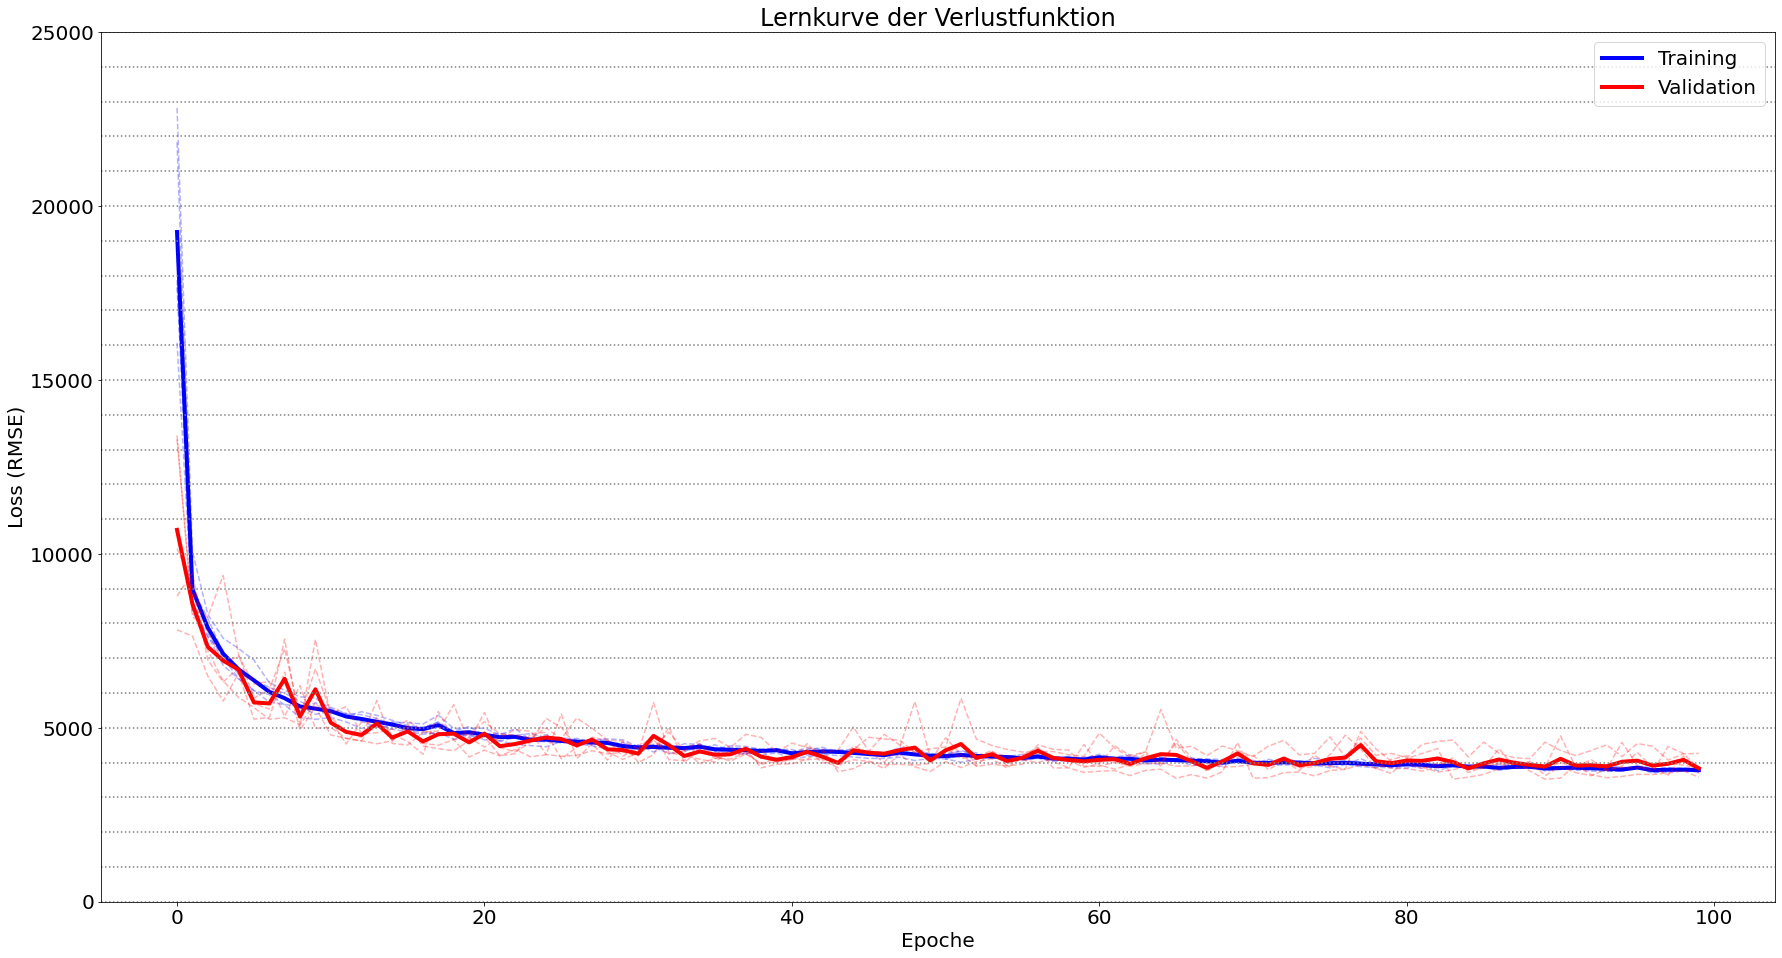

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 25000)

<font size="5">
Das Modell beginnt nun etwas später mit der Konvergenz, allerdings ist beim Training während der Kreuzvalidierungen eine leichte Verbesserung des MAPE auf Trainings- und Testdaten zu erkennen. Eine Überanpassung an die Trainingsdaten ist allerdings nicht erkennbar.
</font>
<br><br>
<font size="5">
Das Modell verbessert sich gleichermaßen bei den Trainings- und Testdaten. Die Unteranpassung wurde durch zusätzliche Neuronen also zumindest teilweise behoben.
</font>


### <font size="5">Test</font>

In [10]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 2s 4ms/step - loss: 0.1574
Epoch 2/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0675
Epoch 3/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0584
Epoch 4/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0524
Epoch 5/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0472
Epoch 6/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0465
Epoch 7/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0465
Epoch 8/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0420
Epoch 9/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0410
Epoch 10/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0398
Epoch 11/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0401
Epoch 12/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0383
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.96           0.98
MAE       4160.0         2795.0
MSE   30600502.0     16411776.0
RMSE      5532.0         4051.0
                               
MAPE      2.55 %         1.76 %


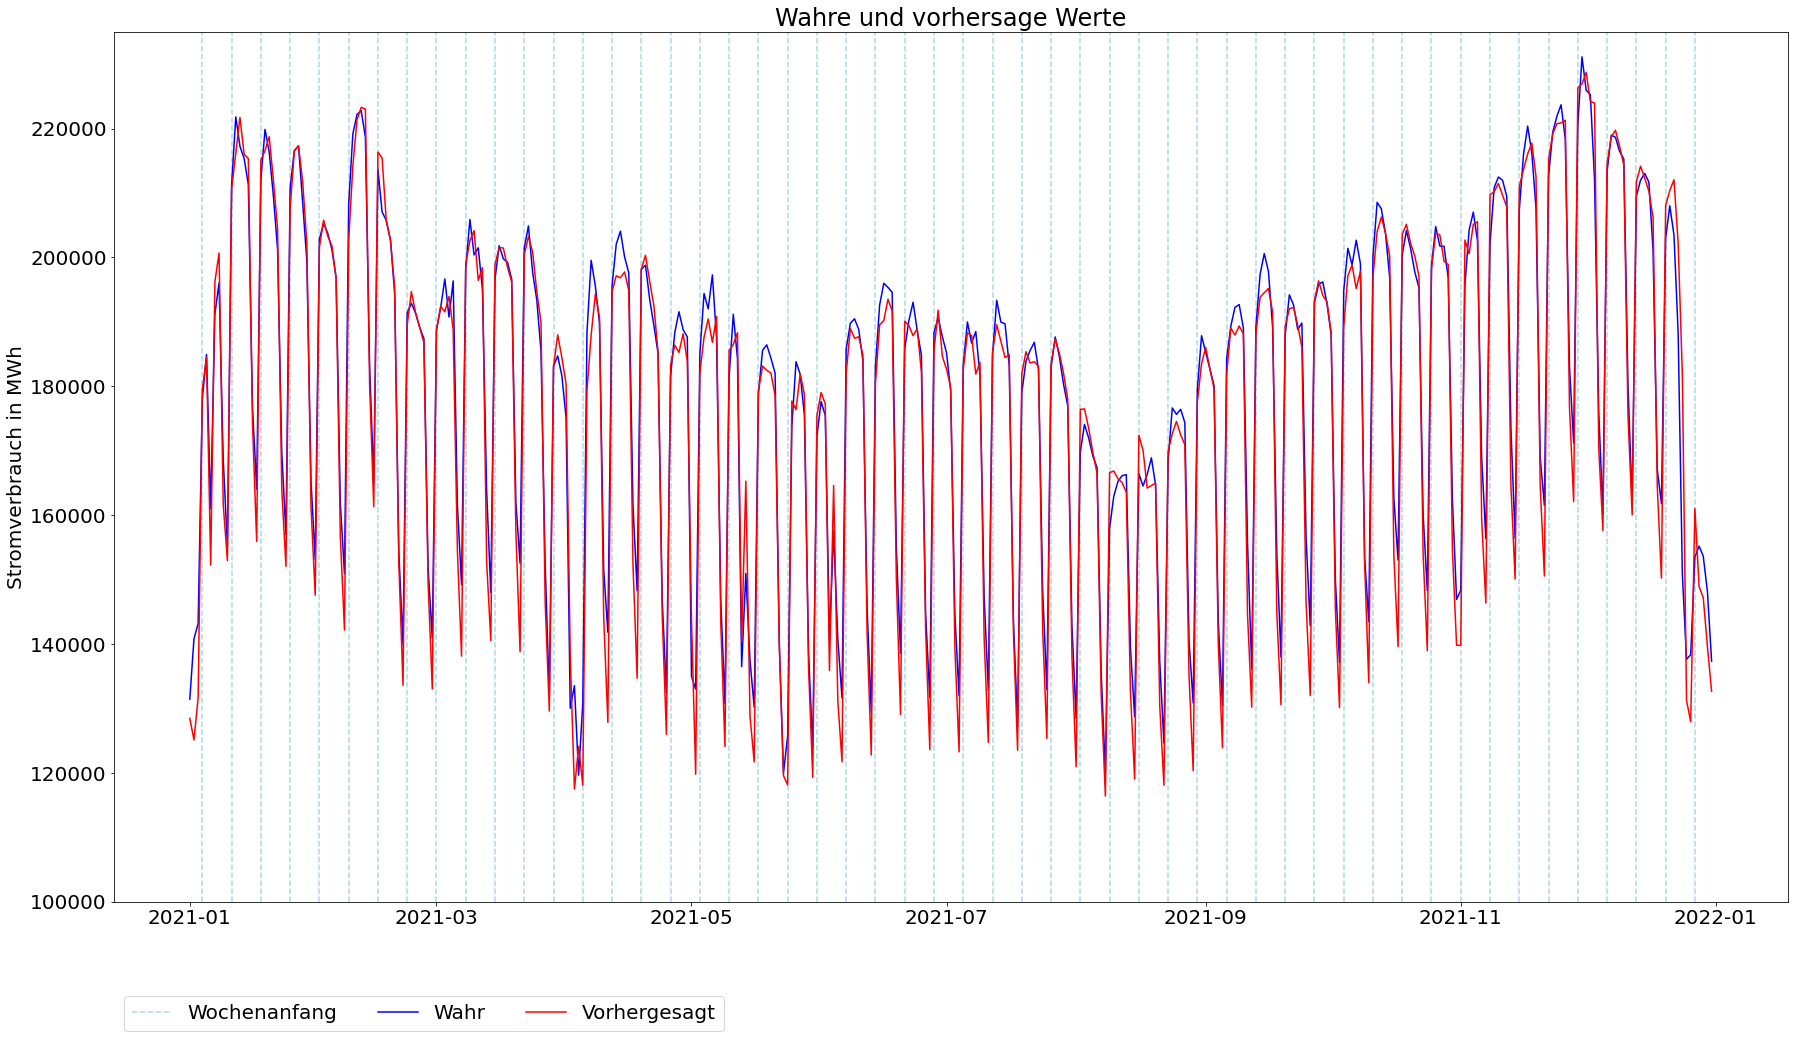

In [11]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-DENSE-3</font><a class="anchor" id="lstm-dense-3"></a>

<font size="5">
Da sich die Unteranpassung durch mehr Neuronen teils beheben lässt, werden die Schichten im nächsten Versuch durch auf 64 bei LSTM und 128 bei Dense erweitert.
<font>


### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
    model.add(Dense(units=128, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.53            1.61               1.84
2             2.34            1.66               1.78
3             2.39            1.71               1.82
4             2.43            1.63               1.92
5             2.39            1.64               1.66
Average       2.42            1.65               1.80





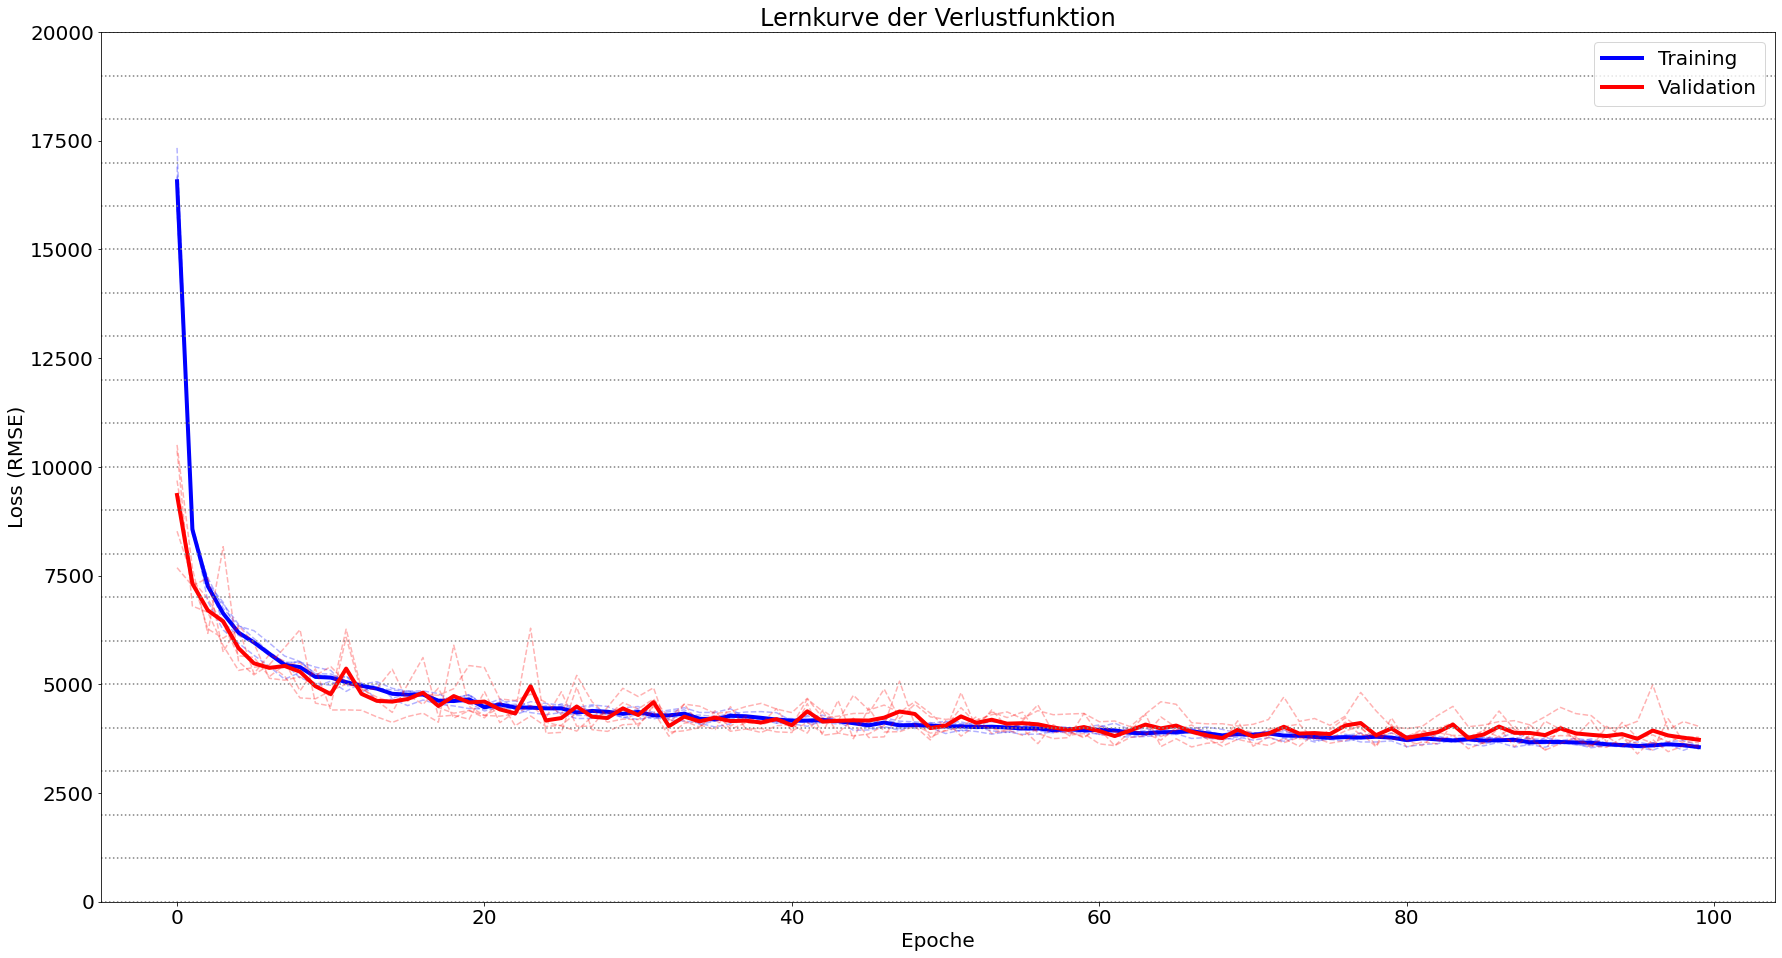

In [10]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 20000)

<font size="5">
Die Lernkurve zeigt, dass ab der etwa 80. Epoche die Überanpassung beginnt. Die Konvergenz des Modells ist aber noch nicht erreicht. Es sind daher möglicherweise weitere Epochen in Verbindung mit Dropouts oder Regularisierung notwendig.
</font>
<br><br>
<font size="5">
Anhand der Metriken lässt sich erkennen, dass das Netz trotz der zusätzlichen Neuronen zunächst sehr ähnlich abschneidet wie das Modell mit 32 und 64 Neuronen. Die erweiterten Schichten bringen also nur stark eingeschränkten Mehrwert.
</font>


### <font size="5">Test</font>

In [11]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 3s 5ms/step - loss: 0.1092
Epoch 2/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0592
Epoch 3/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0532
Epoch 4/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0504
Epoch 5/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0464
Epoch 6/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0436
Epoch 7/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0423
Epoch 8/100
273/273 [==============================] - 2s 5ms/step - loss: 0.0417
Epoch 9/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0390
Epoch 10/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0384
Epoch 11/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0373
Epoch 12/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0378
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.96           0.98
MAE       4092.0         2530.0
MSE   30016600.0     12901419.0
RMSE      5479.0         3592.0
                               
MAPE      2.51 %         1.57 %


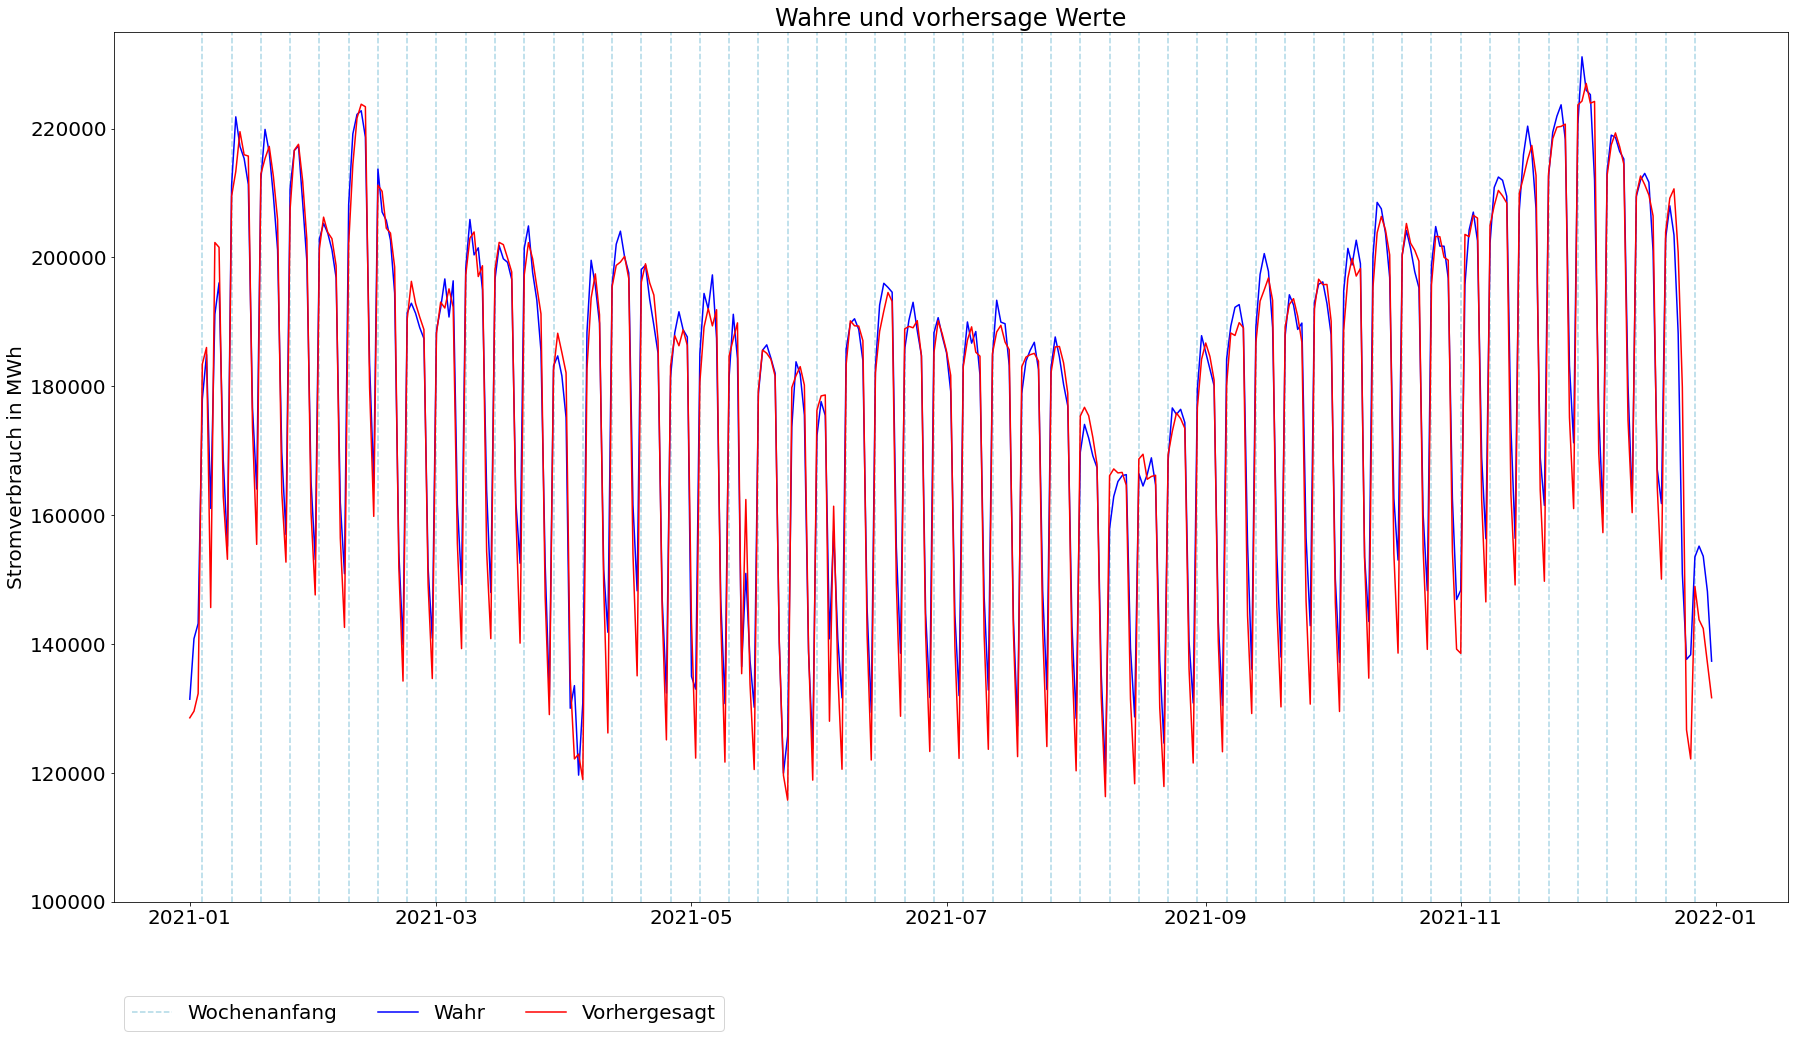

In [12]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-DENSE-4</font><a class="anchor" id="lstm-dense-4"></a>

<font size="5">
Da sich LSTM-DENSE-2 und LSTM-DENSE-3 sehr ähnlich verhalten, wird von einer Erweiterung der Neuronen abgesehen. Stattdessen wird ein Modell wie bei LSTM-DENSE-2 trainiert, jedoch mit mehr Epochen. Es soll dabei überprüft werden, ob ein längeres Training mit gegebenenfalls Dropouts oder Regularisierung zu besseren Ergebnissen führt.
<font>


### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 150
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=False, activation="tanh"))
    model.add(Dense(units=64, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.47            1.61               1.91
2             2.77            2.05               2.18
3             2.86            1.72               1.77
4             2.56            1.45               1.74
5             2.67            1.52               1.61
Average       2.67            1.67               1.84





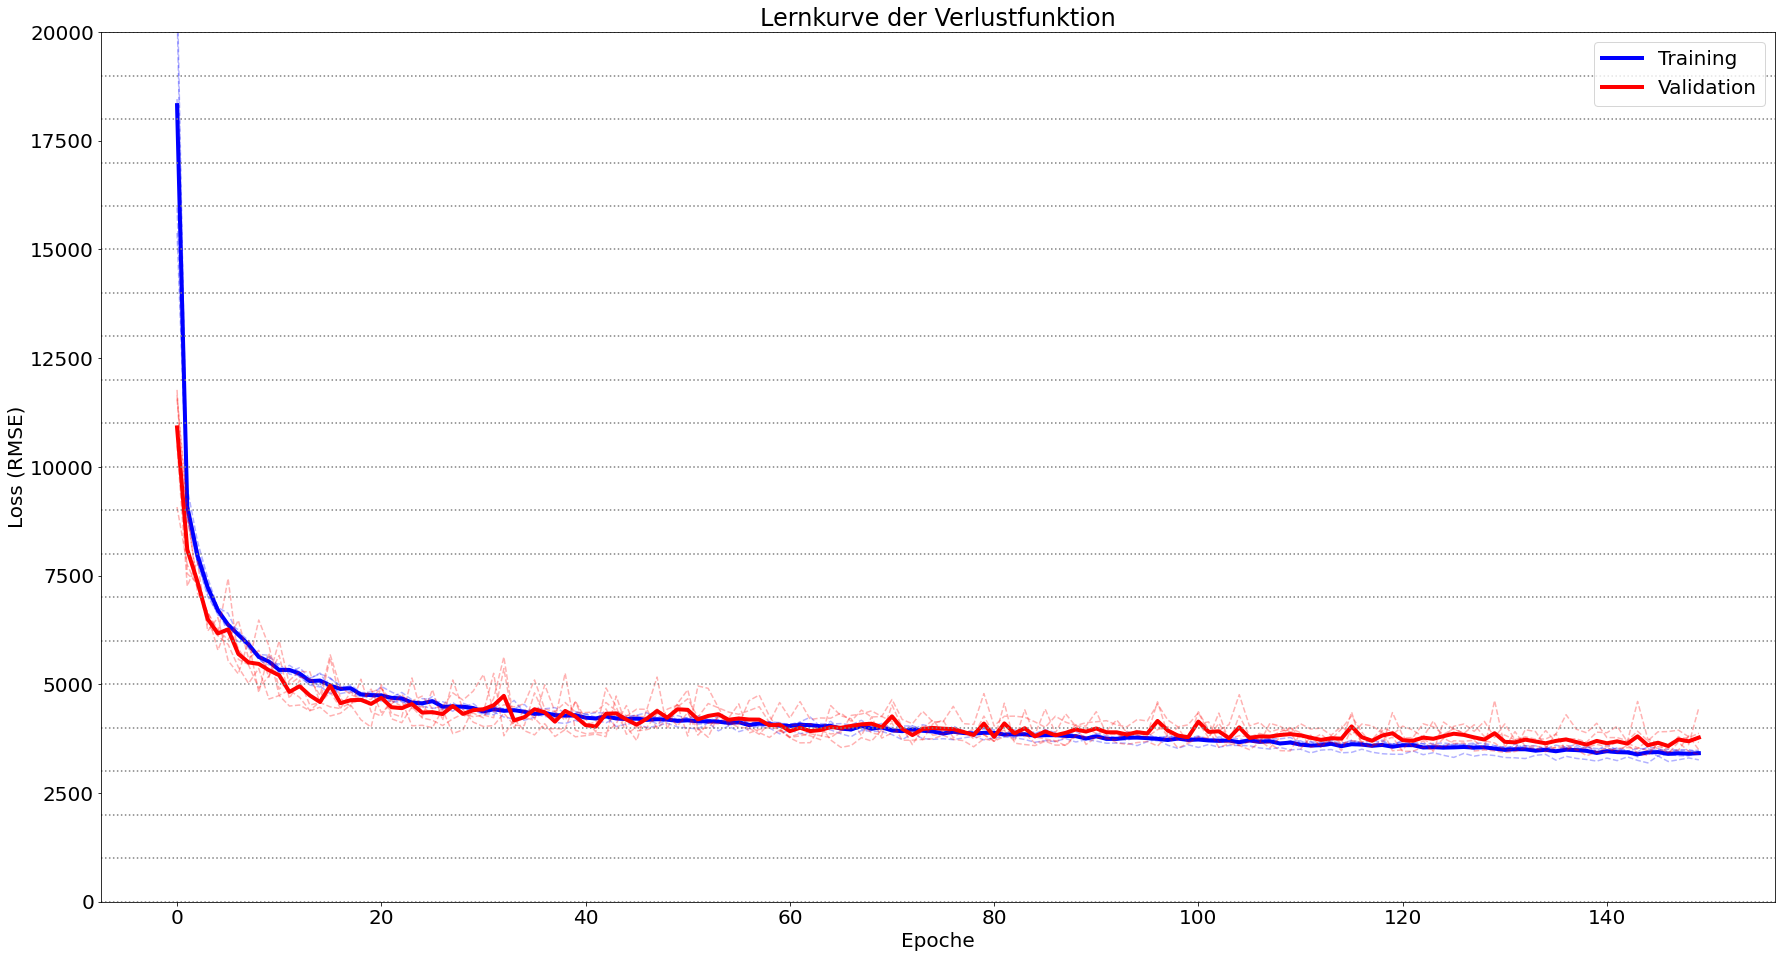

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 20000)

<font size="5">
Durch weitere Epochen scheint zunächst keine große Verbesserung zu entstehen. Der MAPE verhält sich beim Training ähnlich.
</font>


### <font size="5">Test</font>

In [8]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/150
273/273 [==============================] - 3s 4ms/step - loss: 0.1490
Epoch 2/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0614
Epoch 3/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0526
Epoch 4/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0472
Epoch 5/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0453
Epoch 6/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0428
Epoch 7/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0414
Epoch 8/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0396
Epoch 9/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0399
Epoch 10/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0386
Epoch 11/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0381
Epoch 12/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0376
Epoch 13/150


       Testdaten Trainingsdaten
R2          0.96           0.98
MAE       3938.0         2472.0
MSE   27542712.0     12300389.0
RMSE      5248.0         3507.0
                               
MAPE      2.41 %         1.53 %


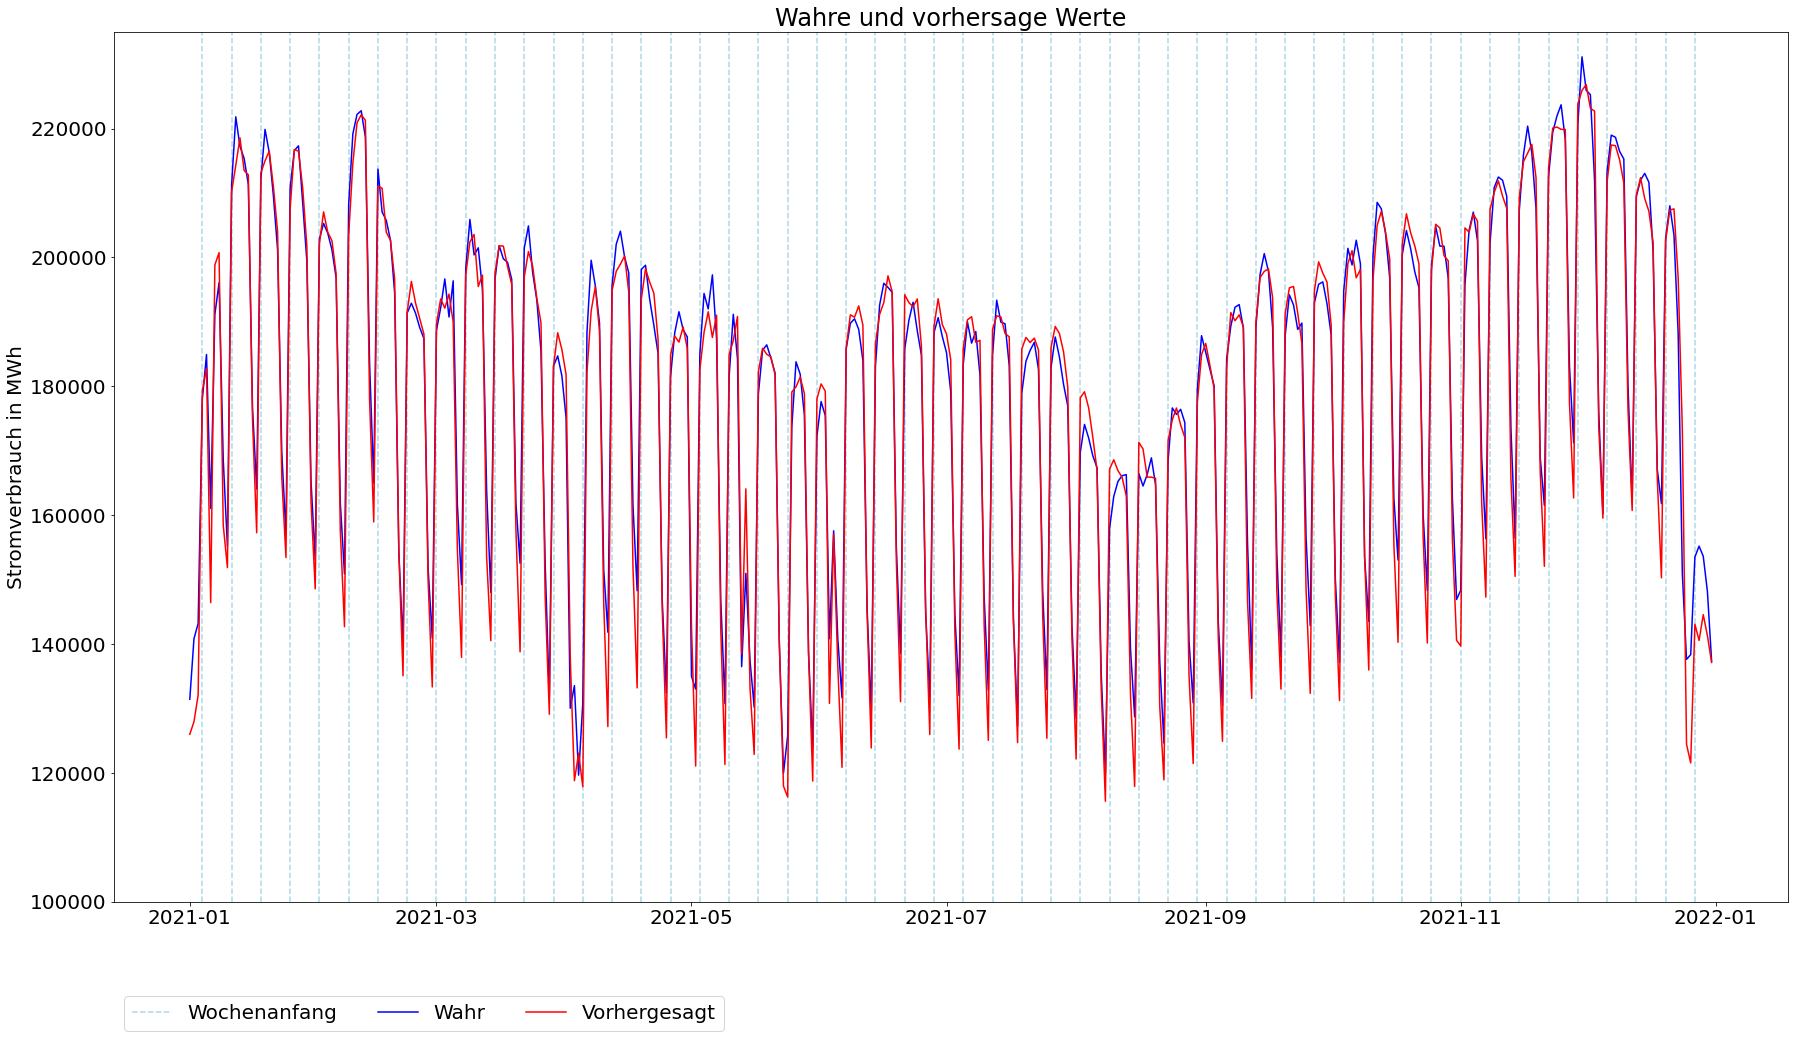

In [9]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-DENSE-5</font><a class="anchor" id="lstm-dense-5"></a>

<font size="5">
Es soll erneut geprüft werden, ob eine niedrigere Lernrate Verbesserungen herbeiführt. Die Lernrate wird also auf 0,0001 heruntergesetzt.
<font>


### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 150
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=False, activation="tanh"))
    model.add(Dense(units=64, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0001)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.57            1.93               1.99
2             2.55            1.93               1.91
3             2.46            1.93               2.02
4             2.38            1.86               2.11
5             2.35            1.98               1.91
Average       2.46            1.93               1.99





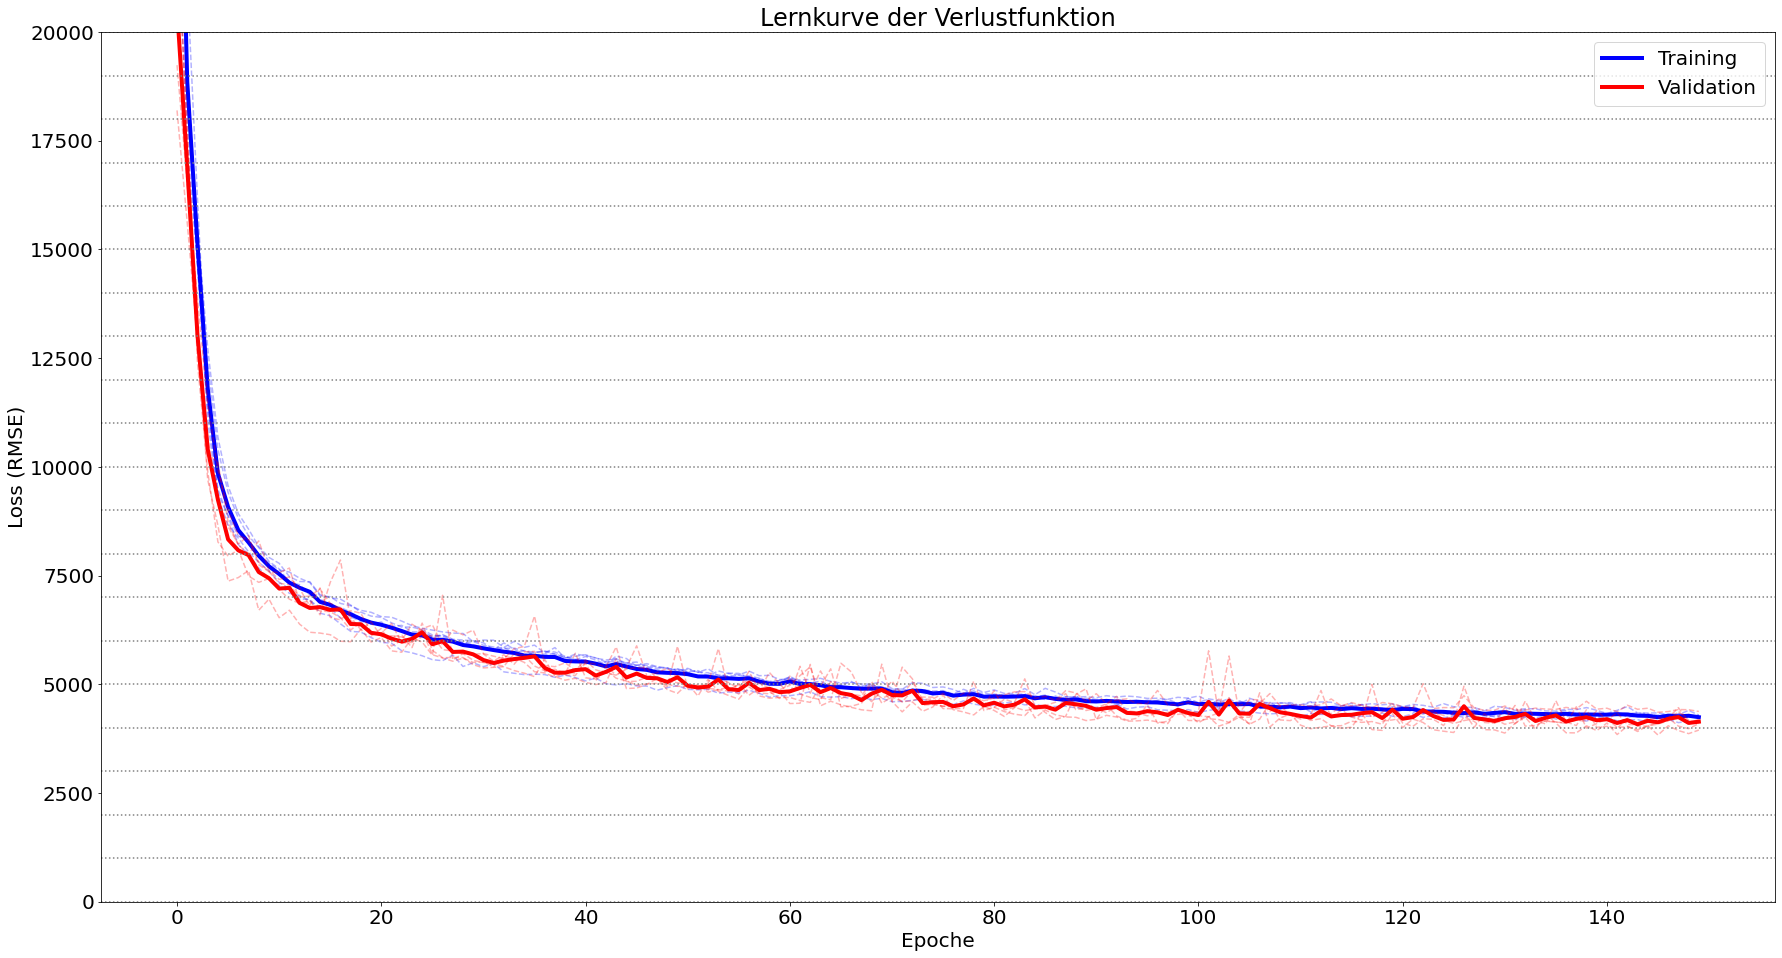

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 20000)

<font size="5">
Durch die niedrigere Lernrate werden die Testdaten gleich gut, die Trainingsdaten allerdings etwas schlechter abgebildet. Der Verlauf der Lernkurve kann nicht geändert werden.
</font>

### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/150
273/273 [==============================] - 2s 4ms/step - loss: 0.2233
Epoch 2/150
273/273 [==============================] - 1s 4ms/step - loss: 0.1498
Epoch 3/150
273/273 [==============================] - 1s 4ms/step - loss: 0.1203
Epoch 4/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0950
Epoch 5/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0764
Epoch 6/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0675
Epoch 7/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0633
Epoch 8/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0597
Epoch 9/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0579
Epoch 10/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0557
Epoch 11/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0549
Epoch 12/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0538
Epoch 13/150


       Testdaten Trainingsdaten
R2          0.96           0.97
MAE       4160.0         3031.0
MSE   30458830.0     21777334.0
RMSE      5519.0         4667.0
                               
MAPE      2.46 %         1.93 %


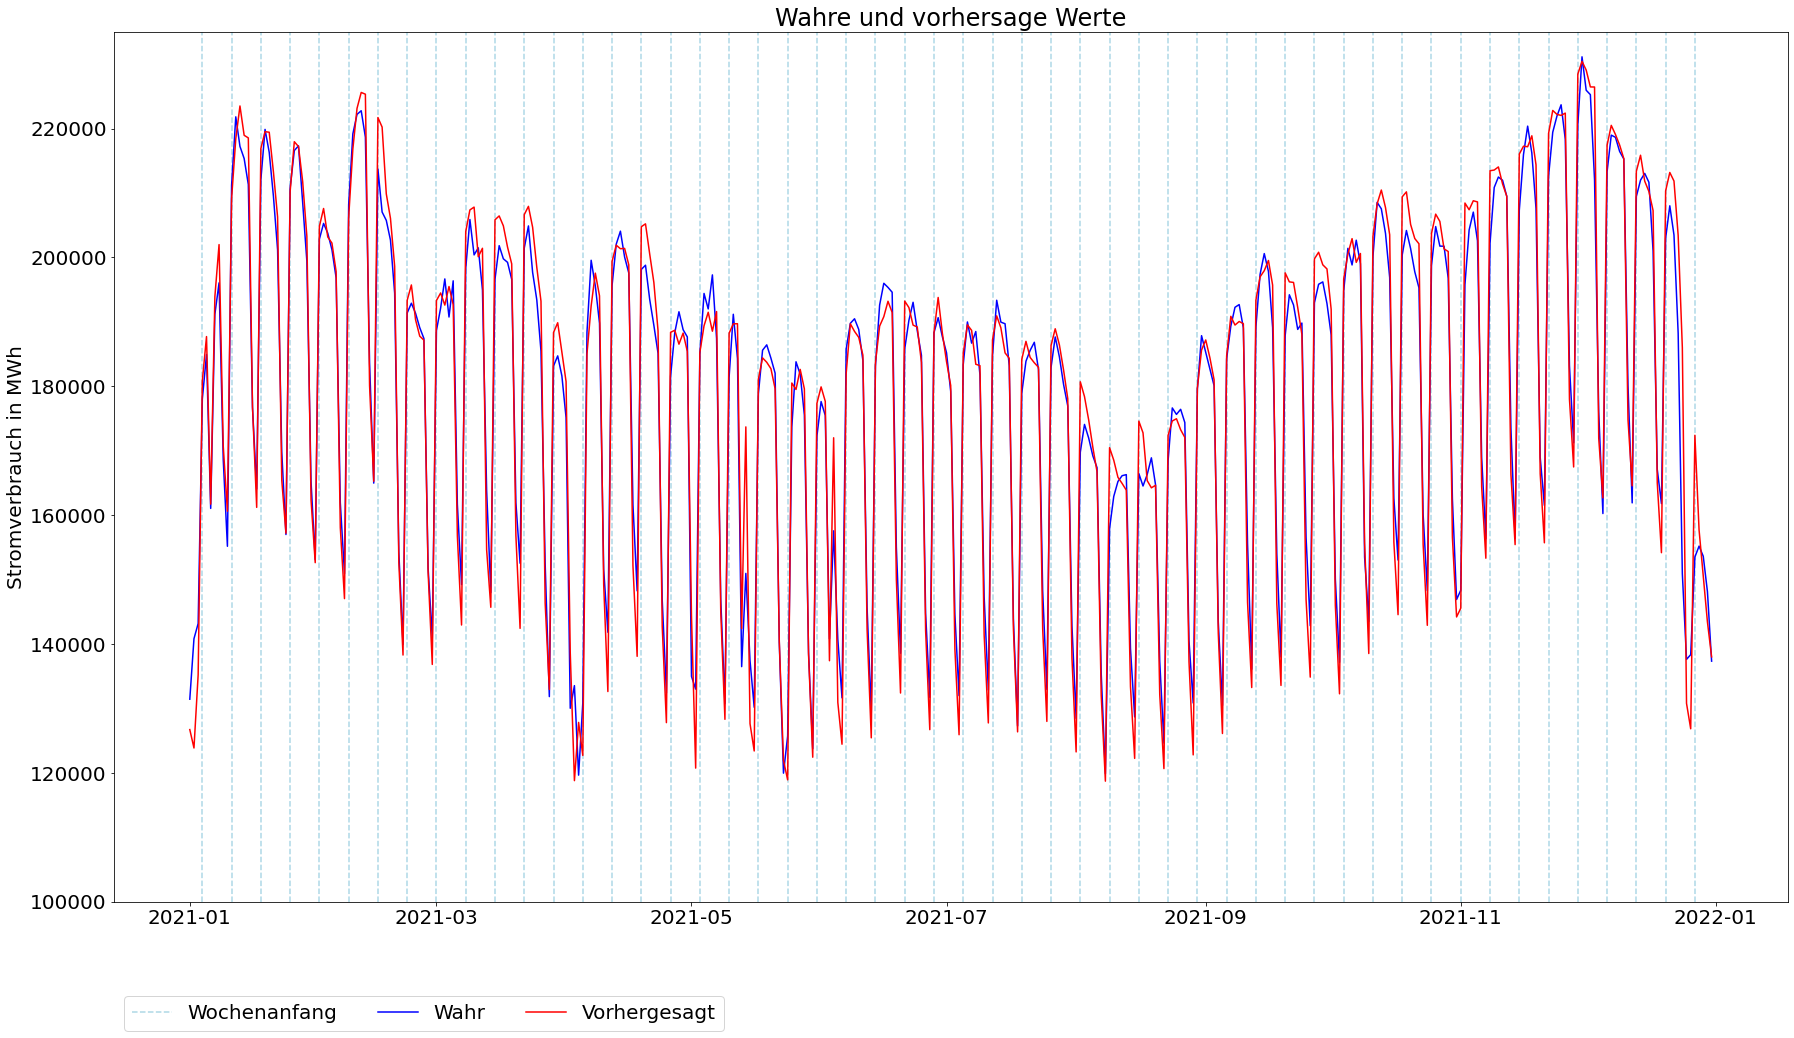

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-DENSE-6</font><a class="anchor" id="lstm-dense-6"></a>

<font size="5">
Die Lernrate wird aus experimentellen Gründen noch weiter heruntergesetzt.
<font>


### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 150
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=False, activation="tanh"))
    model.add(Dense(units=64, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.00005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.54            2.25               2.34
2             2.38            2.23               2.20
3             2.42            2.44               2.44
4             2.20            2.15               2.44
5             2.32            2.30               2.16
Average       2.37            2.27               2.32





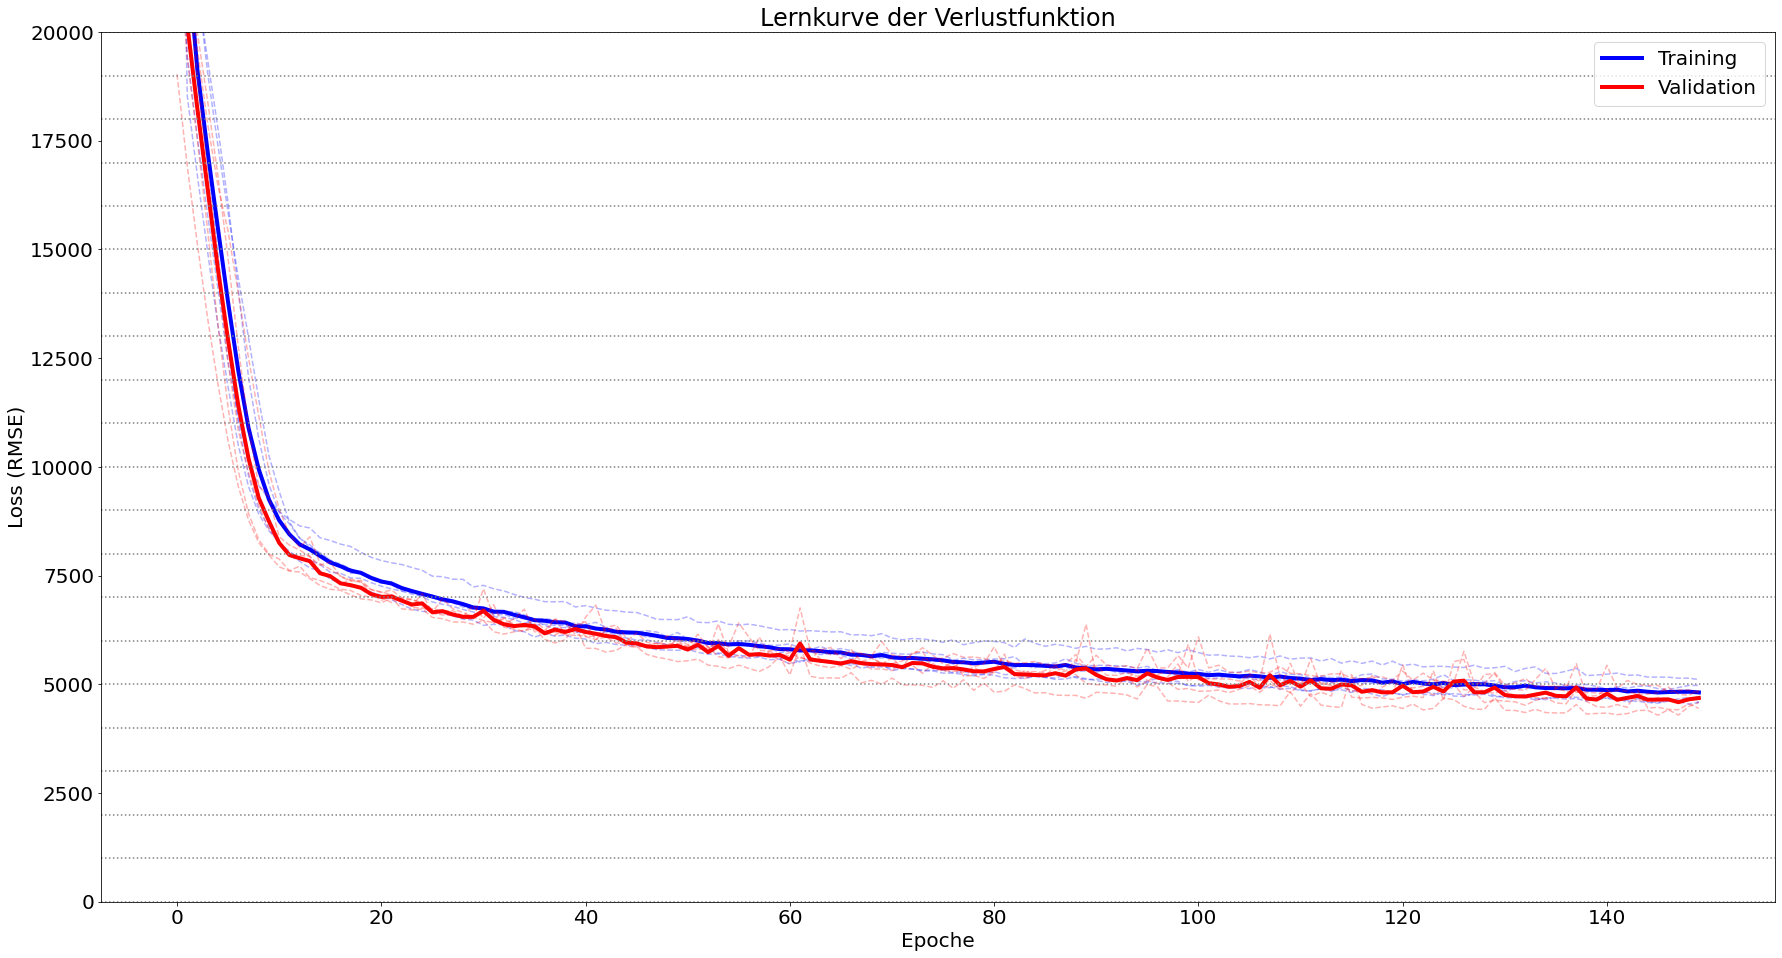

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 20000)

<font size="5">
Der Verlauf der Lernkurve lässt auf eine etwas angemessenere Lernkurve schließen. Allerdings benötigt das Training bei einer derart hohen Lernrate sehr viele Epochen, wobei das Risiko für Überanpassungen steigt. Außerdem wird das Training dadurch sehr ressourcenintensiv.
</font>
<br><br>
<font size="5">
Zusätzlich muss angemerkt werden, dass das Modell nach etwa 150 Epochen bereits langsam mit der Konvergenz beginnt oder diese sich zumindest abzeichnet. Weitere Epochen würden also vermutlich relativ wenig Verbesserungen bringen. Der MAPE wurde beim aktuellen Netz nur sehr geringfügig verbessert. Daher wird ein anderer Ansatz verfolg, nämlich das Netz durch eine vor der LSTM-Schicht geschaltete Dense-Schicht zu verbessern.
</font>


### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/150
273/273 [==============================] - 3s 4ms/step - loss: 0.3292
Epoch 2/150
273/273 [==============================] - 1s 4ms/step - loss: 0.1763
Epoch 3/150
273/273 [==============================] - 1s 4ms/step - loss: 0.1555
Epoch 4/150
273/273 [==============================] - 1s 4ms/step - loss: 0.1391
Epoch 5/150
273/273 [==============================] - 1s 4ms/step - loss: 0.1234
Epoch 6/150
273/273 [==============================] - 1s 4ms/step - loss: 0.1093
Epoch 7/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0987
Epoch 8/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0905
Epoch 9/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0834
Epoch 10/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0777
Epoch 11/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0747
Epoch 12/150
273/273 [==============================] - 1s 4ms/step - loss: 0.0725
Epoch 13/150


       Testdaten Trainingsdaten
R2          0.96           0.96
MAE       3861.0         3314.0
MSE   30114644.0     26857096.0
RMSE      5488.0         5182.0
                               
MAPE       2.3 %         2.12 %


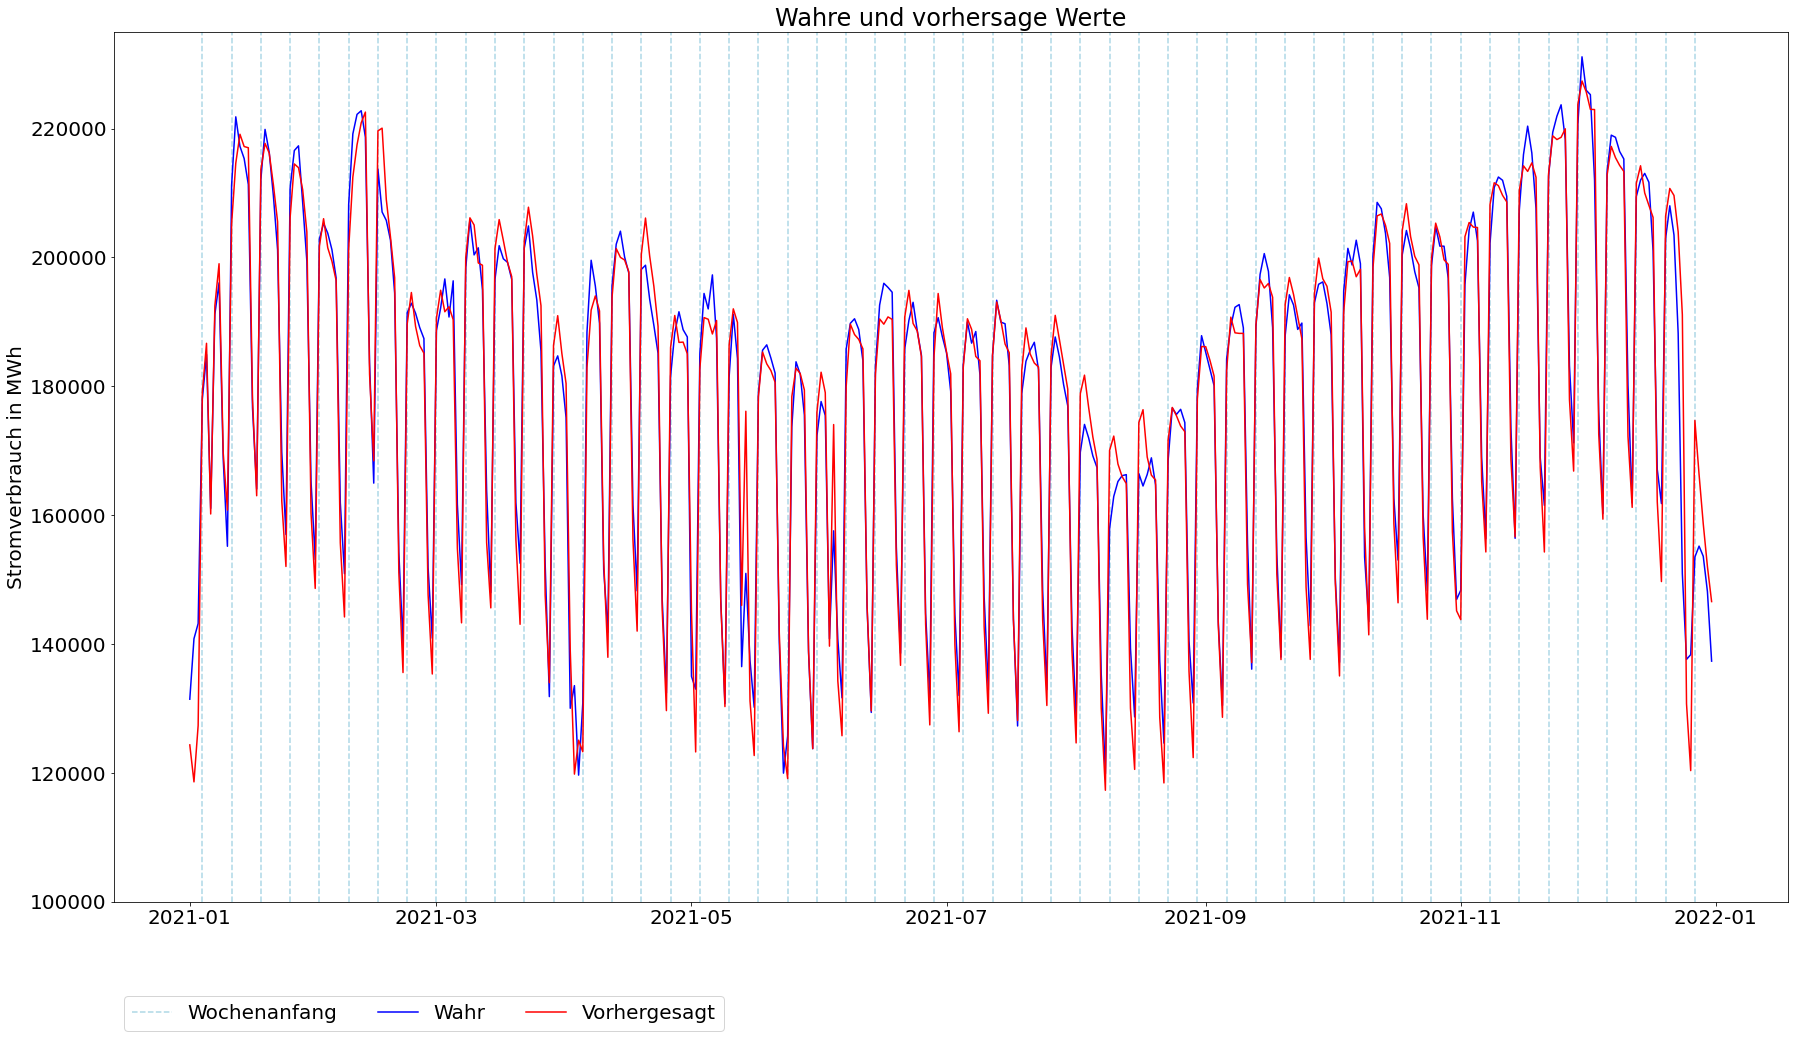

In [7]:
## Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-DENSE-7</font><a class="anchor" id="lstm-dense-7"></a>

<font size="5">
Da auch die Fensterlänge optimiert werden soll, wird im Folgenden ein von 14 Tagen verkürztes Fenster mit nur 7 Tagen getestet.
</font>


### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 150
batch_size = 8

window_size = 7

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=False, activation="tanh"))
    model.add(Dense(units=64, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.05            1.78               1.84
2             2.38            1.63               1.69
3             2.45            1.82               1.98
4             2.25            1.57               1.85
5             2.33            1.66               1.76
Average       2.29            1.69               1.82





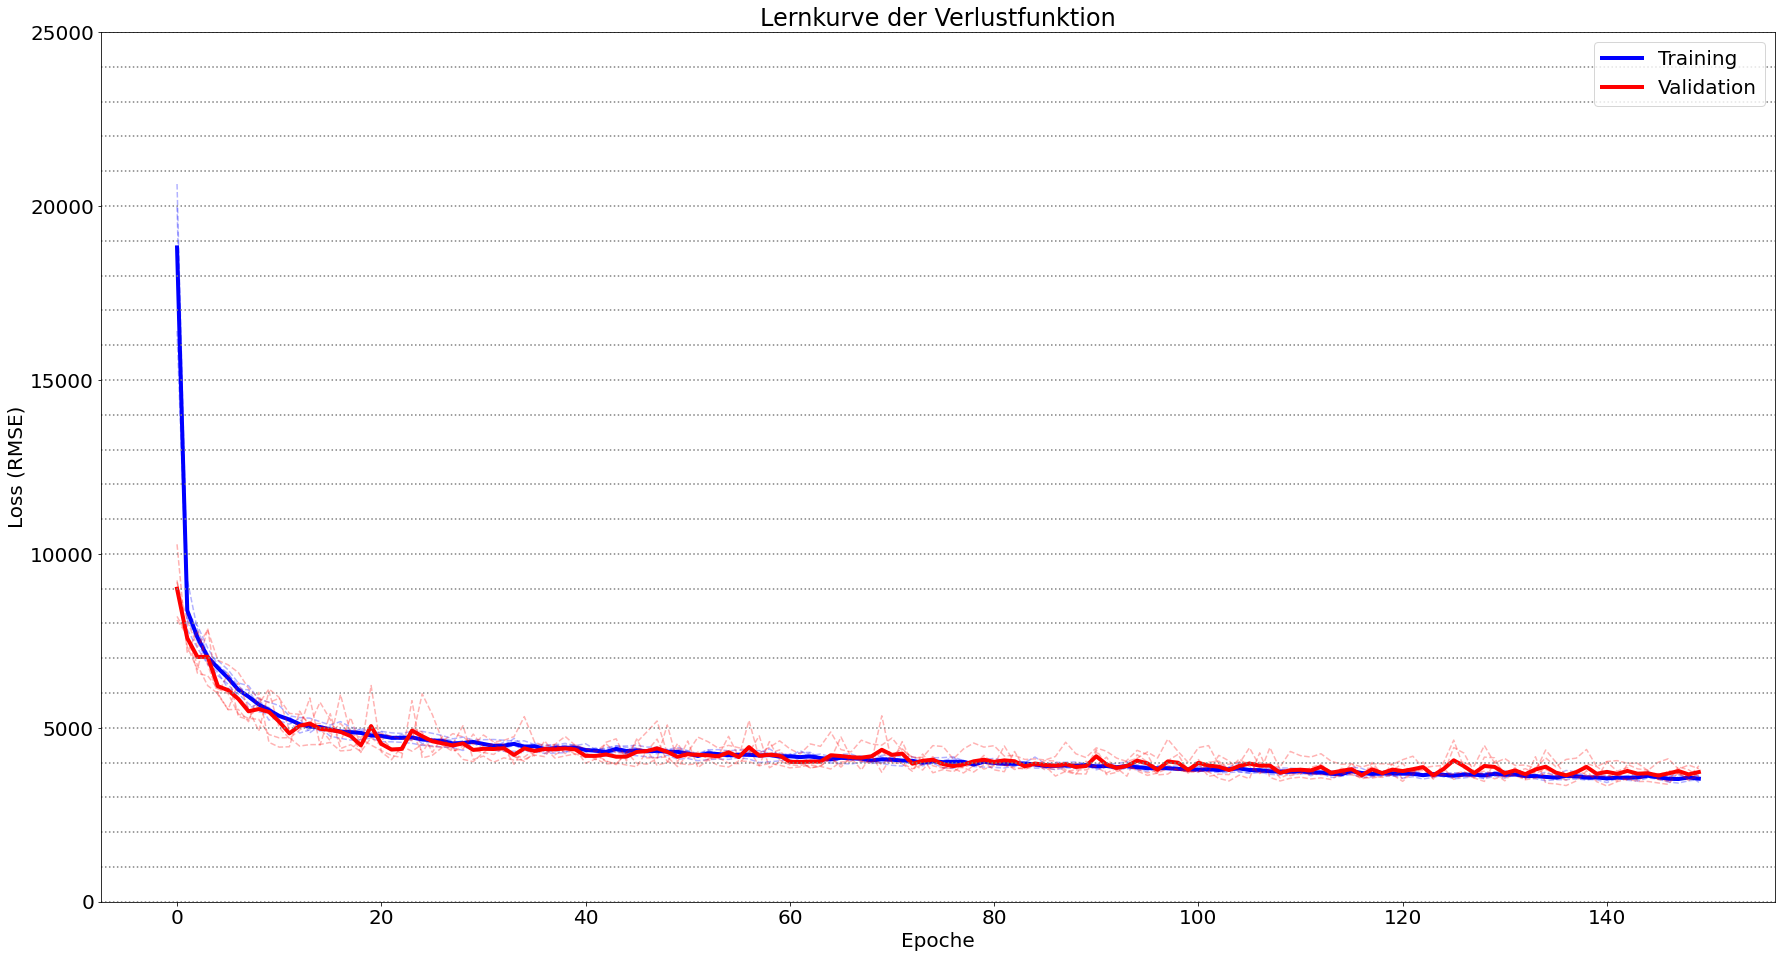

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 25000)

<font size="5">
Der MAPE verändert sich durch das kürzere Fenster geringfügig während der Kreuzvalidierungen, beim finalen Test zeigt sich aber im Vergleich zu LSTM-DENSE-4 keine wirkliche Veränderung.
</font>


### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/150
274/274 [==============================] - 3s 3ms/step - loss: 0.1070
Epoch 2/150
274/274 [==============================] - 1s 3ms/step - loss: 0.0587
Epoch 3/150
274/274 [==============================] - 1s 3ms/step - loss: 0.0543
Epoch 4/150
274/274 [==============================] - 1s 3ms/step - loss: 0.0523
Epoch 5/150
274/274 [==============================] - 1s 3ms/step - loss: 0.0494
Epoch 6/150
274/274 [==============================] - 1s 3ms/step - loss: 0.0462
Epoch 7/150
274/274 [==============================] - 1s 3ms/step - loss: 0.0448
Epoch 8/150
274/274 [==============================] - 1s 3ms/step - loss: 0.0434
Epoch 9/150
274/274 [==============================] - 1s 3ms/step - loss: 0.0405
Epoch 10/150
274/274 [==============================] - 1s 3ms/step - loss: 0.0410
Epoch 11/150
274/274 [==============================] - 1s 3ms/step - loss: 0.0382
Epoch 12/150
274/274 [==============================] - 1s 3ms/step - loss: 0.0379
Epoch 13/150


       Testdaten Trainingsdaten
R2          0.96           0.98
MAE       3961.0         2624.0
MSE   25919665.0     14660269.0
RMSE      5091.0         3829.0
                               
MAPE      2.38 %         1.63 %


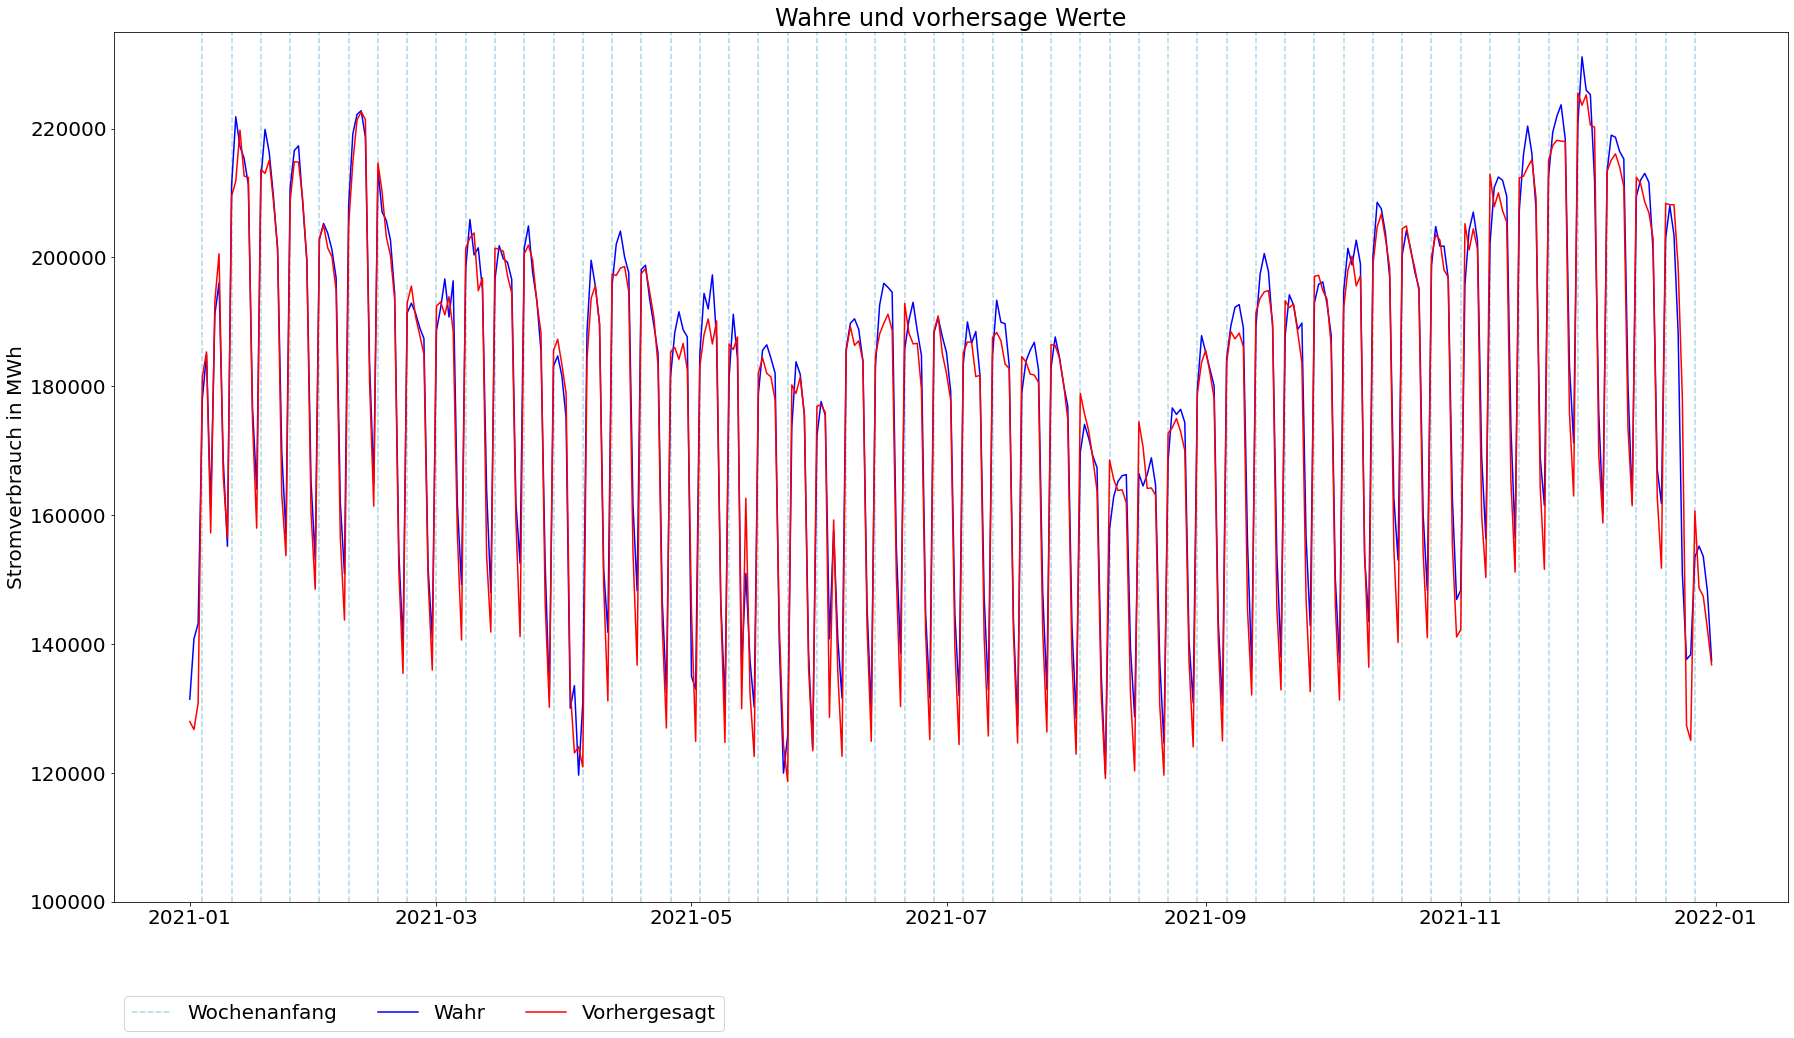

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-DENSE-8</font><a class="anchor" id="lstm-dense-8"></a>

<font size="5">
Es wird ebenfalls getestet, wie sich eine Verlängerung des Fensters von 14 auf 21 Beobachtungen auswirkt.
</font>


### <font size="5">Modell und Parameter</font>

In [8]:
#Hyperparameter
epochs = 150
batch_size = 8

window_size = 21

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=False, activation="tanh"))
    model.add(Dense(units=64, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [9]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [10]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.47            1.58               1.63
2             2.75            1.67               1.65
3             2.93            1.86               2.08
4             3.19            1.91               2.22
5             2.19            1.72               2.03
Average       2.71            1.75               1.92





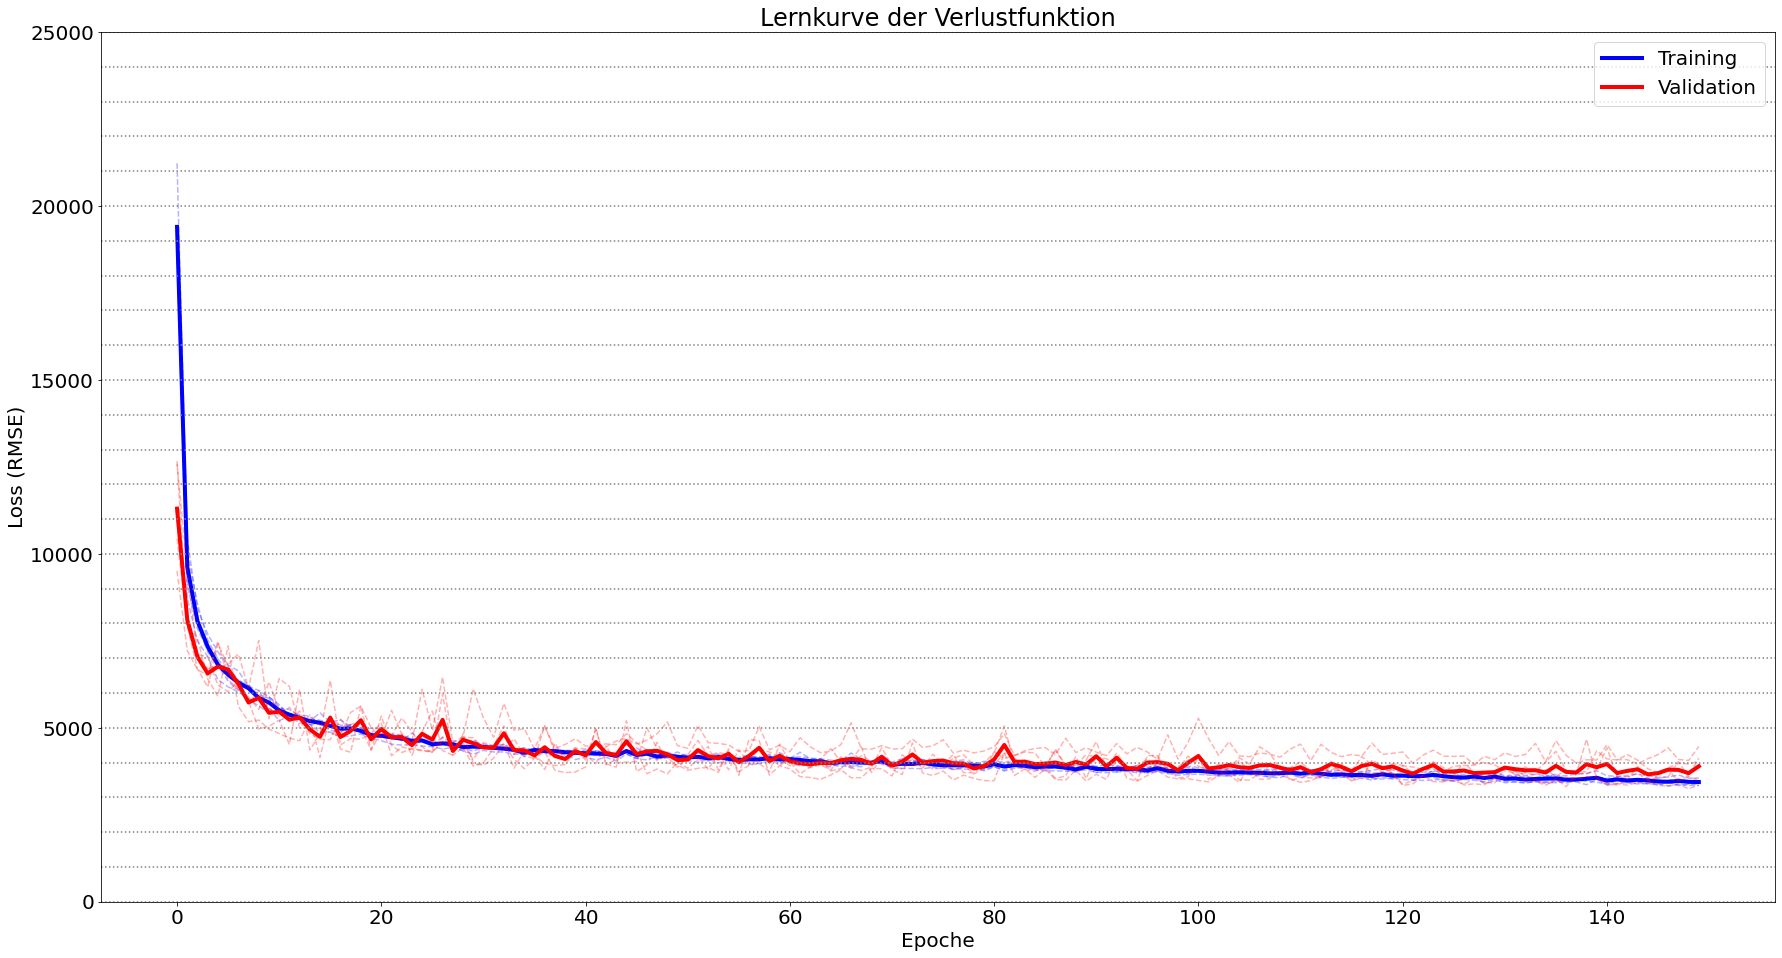

In [11]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 25000)

<font size="5">
Der MAPE steigt durch das verlängerte Fenster im Vergleich zu DENSE-LSTM-4 ein wenig an, außerdem sind leichte Überanpassungen zu erkennen. Ein längeres Fenster bringt also keine Verbesserungen.
</font>


### <font size="5">Test</font>

In [12]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/150
272/272 [==============================] - 3s 7ms/step - loss: 0.1323
Epoch 2/150
272/272 [==============================] - 2s 7ms/step - loss: 0.0630
Epoch 3/150
272/272 [==============================] - 2s 7ms/step - loss: 0.0559
Epoch 4/150
272/272 [==============================] - 2s 7ms/step - loss: 0.0531
Epoch 5/150
272/272 [==============================] - 2s 7ms/step - loss: 0.0499
Epoch 6/150
272/272 [==============================] - 2s 7ms/step - loss: 0.0494
Epoch 7/150
272/272 [==============================] - 2s 7ms/step - loss: 0.0480
Epoch 8/150
272/272 [==============================] - 2s 7ms/step - loss: 0.0439
Epoch 9/150
272/272 [==============================] - 2s 8ms/step - loss: 0.0423
Epoch 10/150
272/272 [==============================] - 2s 9ms/step - loss: 0.0412
Epoch 11/150
272/272 [==============================] - 2s 7ms/step - loss: 0.0398
Epoch 12/150
272/272 [==============================] - 2s 7ms/step - loss: 0.0399
Epoch 13/150


       Testdaten Trainingsdaten
R2          0.96           0.98
MAE       4078.0         2458.0
MSE   29155808.0     12671160.0
RMSE      5400.0         3560.0
                               
MAPE      2.44 %         1.53 %


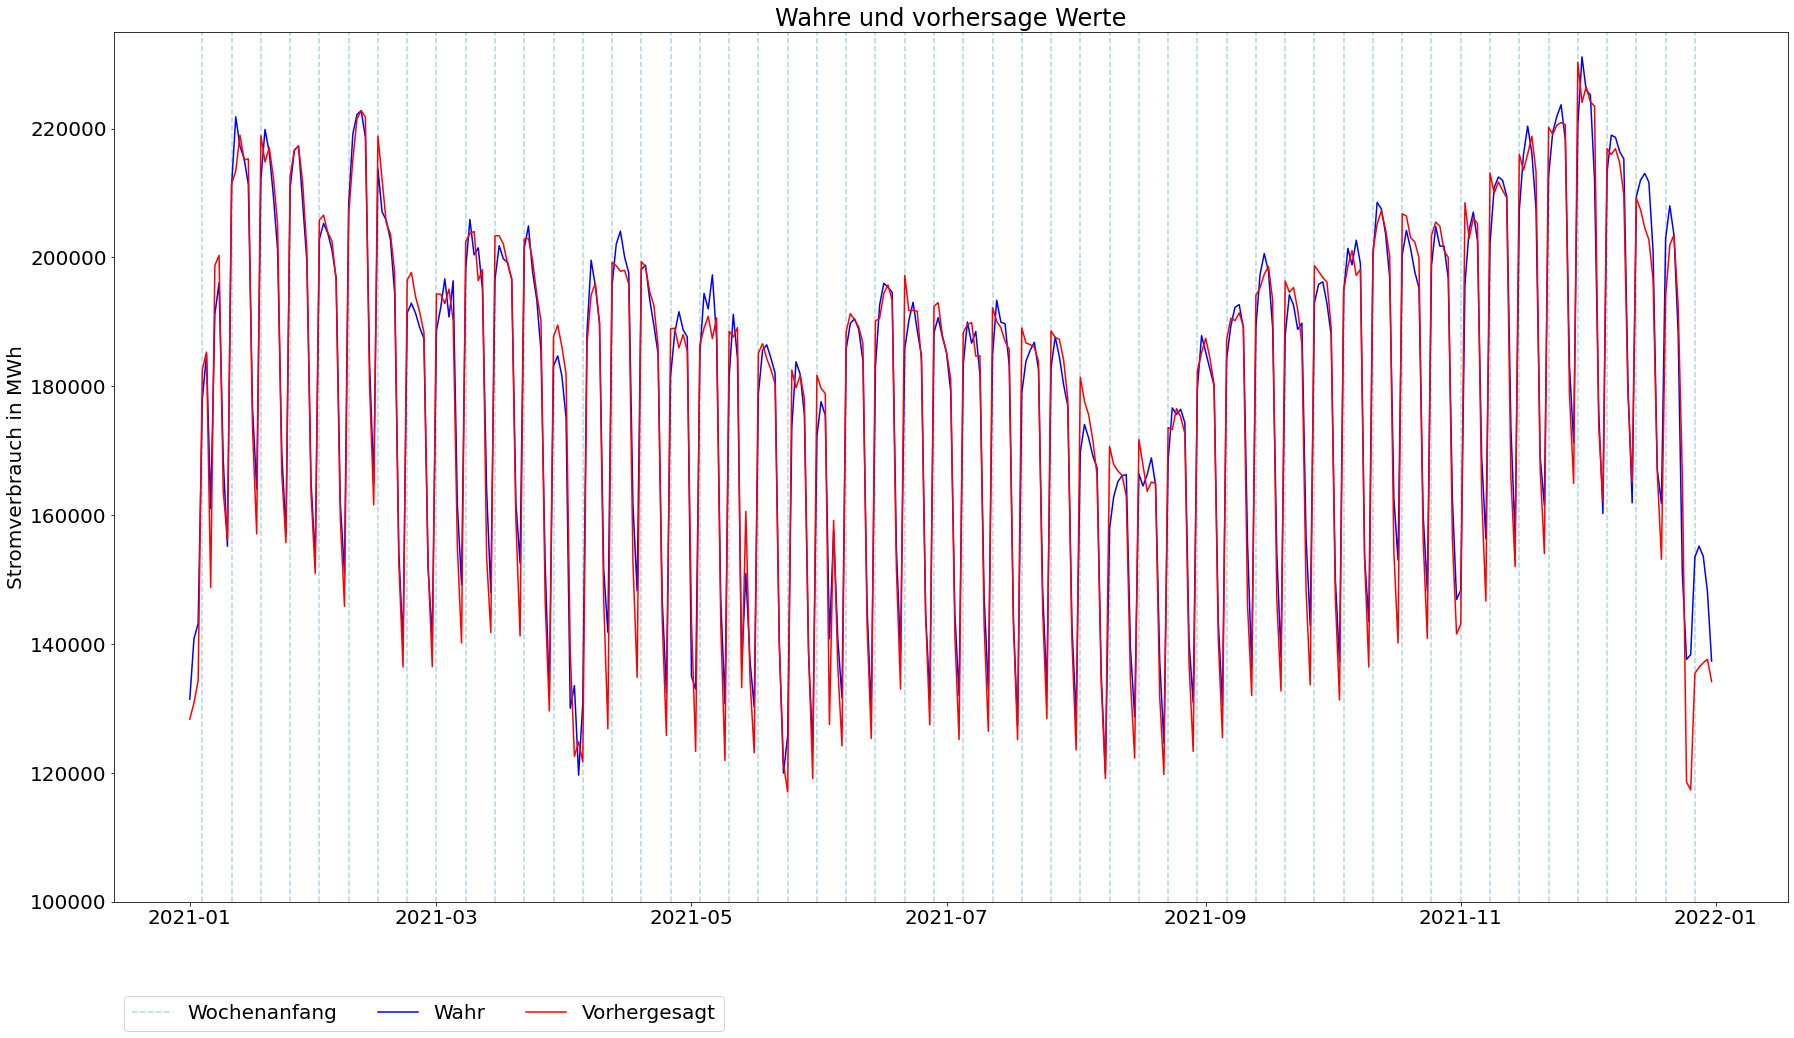

In [13]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)